# Initial Conditions for an N-Body Simulation

Let's generate a realization of a Hernquist (1990) profile for a dark matter halo with total mass $M=10^{12}\,M_{\odot}$ and scale radius $a=35\,{\rm kpc}$ using $N=10^6$ particles.

In [6]:
%matplotlib inline
import numpy
import matplotlib 
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline as US
import scipy.integrate as s_int
import time

time0=time.time()

# total number of particles
nptot=10**6
# total mass of halo (in M_sun)
mtot=1e12
# Hernquist scale radius (in kpc)
aa=35.0

# Newton's constant, where M is in M_sun, v is in km/s, and r is in kpc:
gn=4.30071e-6

In [7]:
# set random state for reproducible results:
my_randState=numpy.random.RandomState(seed=8675309)

The basic idea is that we want to draw $(x,y,z)$ such that the radii $r=\sqrt{x^2+y^2+z^2}$ are distributed as $\rho_{\rm Hern}(r)$.

# Drawing positions

The probability of a randomly selected particle having a radius $r$ is just propotional to the probability of finding a mass element at radius $r$: 
$$dP \propto dM = 4\pi r^2\,\rho(r) \,dr\,$$
This means we can randomly select radii $r$ by randomly selecting numbers from a uniform distribution between $0$ and $M$, then finding the corresponding radius. That is, we want to find $r$ corresponding to each $M$.

Fortunately, it is easy to invert $M(r)$ to get $r(M)$:
$$r(M)=\frac{1}{M^{-1/2}-1}$$

In the lines below, I select the random numbers, then find the corresponding radii. 

In [8]:
randvs_r=my_randState.rand(nptot)
rvals=numpy.sort(1/(randvs_r**(-0.5)-1.))

Now I have a radius for each particle. I need to convert from spherical to cartesian coordinates:

In [9]:
rvals *= aa

# random numbers for phi, theta, v_phi, v_theta:
new_randvec=my_randState.rand(2, nptot)

pos=numpy.zeros((nptot, 3), dtype='float32')

phir=2e0*pi*new_randvec[0]
thetar=numpy.arccos(1e0-2e0*new_randvec[1])

pos[:,0]=rvals*numpy.sin(thetar)*numpy.cos(phir)
pos[:,1]=rvals*numpy.sin(thetar)*numpy.sin(phir)
pos[:,2]=rvals*numpy.cos(thetar)

ttot=time.time()-time0
print('total time elapsed: {0:.2f} seconds'.format(ttot))

total time elapsed: 2.22 seconds


OK, that's it! We've got a code that sets up positions for a Hernquist dark matter halo (?) with $10^6$ particles that runs in a few seconds. 

# Some tests

I'll test that we have the right mass distribution by comparing directly to the Hernquist profile. I'll bin up the halo profile in equally spaced logarithmic bins (note the function is basically a power-law, so log bins make much more sense than linear):

In [10]:
minlogr=numpy.log10(rvals.min())
maxlogr=numpy.log10(rvals.max())
# binsize, in log10:
logbinsize=0.15
binedges=numpy.r_[minlogr:maxlogr:logbinsize]

numbins=binedges.size-1
rhobinned, edges_test=numpy.histogram(numpy.log10(rvals), binedges)

In [11]:
numpy.allclose(binedges, edges_test)

True

To get density, we use 

$$\rho(r)=\frac{dM}{4\pi\,r^3\,d\log\,r}$$

This applies to a density estimate calculated at the (logarithmic) midpoint of the bin.

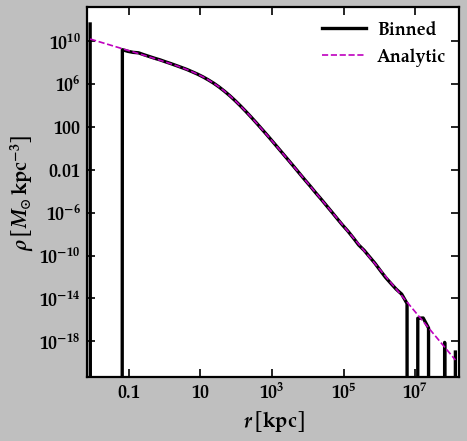

In [12]:
bincenters=10.**(binedges[:-1]+logbinsize/2.0)
rho=rhobinned*(mtot/nptot)/4./numpy.pi/logbinsize/numpy.log(10)/bincenters**3
def hernquist_rho(rr): return mtot/2/numpy.pi/aa**3/(rr/aa)/(1+rr/aa)**3
plt.figure(figsize=(6,6))
plt.loglog(bincenters, rho, 'k-', lw=3, label='Binned')
plt.loglog(bincenters, hernquist_rho(bincenters), 'm--', lw=1.5, label='Analytic')
plt.xlim(10.**(minlogr), 10.**(maxlogr))
plt.xlabel(r'$r\,[{\rm kpc}]$')
plt.ylabel(r'$\rho\,[M_{\odot}\,{\rm kpc}^{-3}]$')
plt.legend(frameon=False)

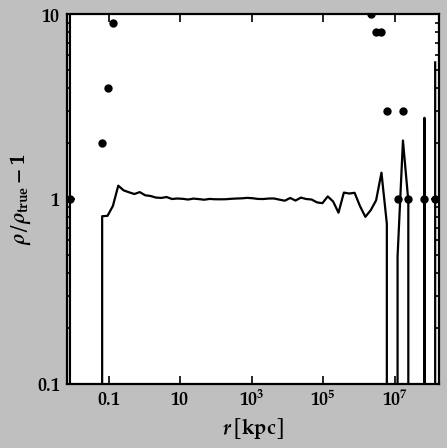

In [11]:
plt.figure(figsize=(6,6))
plt.loglog(bincenters, rho/hernquist_rho(bincenters), lw=2)
plt.xlim(10.**(minlogr), 10.**(maxlogr))
plt.xlabel(r'$r\,[{\rm kpc}]$')
plt.ylabel(r'$\rho/\rho_{\rm true}-1$')
plt.ylim(0.1, 10)
plt.plot(bincenters, rhobinned, 'ko')
# plot the fractional difference, along with the number of points in each bin:

Let's print out the number of elements in each bin:

In [9]:
rhobinned

array([     1,      0,      0,      0,      0,      0,      2,      4,
            9,     23,     43,     83,    160,    321,    600,   1145,
         2130,   3948,   7241,  12383,  20886,  32990,  48464,  67215,
        84047,  96023, 102327,  99200,  89928,  76961,  63067,  49723,
        38069,  28646,  20995,  15159,  10936,   7906,   5657,   3976,
         2792,   2052,   1411,   1038,    723,    509,    348,    244,
          188,    125,     77,     70,     49,     35,     21,     13,
           10,      8,      8,      3,      0,      1,      3,      1,
            0,      0,      1,      0,      1])